In [1]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
stock_to_use = "META"

In [33]:
startDate = datetime(2013, 1, 1)

endDate = datetime(2023, 12, 31)
 
# pass the parameters as the taken dates for start and end
df = pd.DataFrame(yf.download(stock_to_use, start=startDate, end=endDate)['Adj Close'])
df = df.rename(columns={"Adj Close":"Close"})
#df.plot()

def double_bollinger_bands(df, window=20):
    rolling_mean = df["Close"].rolling(window).mean()
    rolling_std = df["Close"].rolling(window).std()
    
    upper_band1 = rolling_mean + (rolling_std)
    lower_band1 = rolling_mean - (rolling_std)
    upper_band2 = rolling_mean + (rolling_std * 2)
    lower_band2 = rolling_mean - (rolling_std * 2)
    
    df['Upper_Band1'] = upper_band1
    df['Lower_Band1'] = lower_band1
    df['Upper_Band2'] = upper_band2
    df['Lower_Band2'] = lower_band2
    
    df['Buy_Signal'] = np.where((df["Close"] < df['Lower_Band1']) & (df["Close"] > df['Lower_Band2']), 1, 0)
    df['Sell_Signal'] = np.where((df["Close"] > df['Upper_Band1']) & (df["Close"] < df['Upper_Band2']), 1, 0)
    
    return df

df = double_bollinger_bands(df)

initial_capital = 10000
min_transaction_size = 1

def backtest(df, initial_capital):
    
    position = 0
    cash = initial_capital
    portfolio_value = []
    
    for date, row in df.iterrows(): #assume we can buy as many as can, and sell all if possible, naive strategy
        if row['Buy_Signal'] and cash >= row["Close"]:
            shares_to_buy = cash // row["Close"]
            cash -= shares_to_buy * row["Close"]
            position += shares_to_buy
        
        elif row['Sell_Signal'] and position != 0:
            cash += position * row["Close"]
            position = 0

        total_value = cash + (position * row["Close"])
        portfolio_value.append(total_value)

    df["Portfolio_Value"] = portfolio_value
    
    return df
    
    
df = backtest(df, initial_capital)

def compute_metrics(stock_data, initial_capital=10000):
    returns = stock_data['Close'].pct_change().dropna()
    total_return = (stock_data['Close'][-1] - stock_data['Close'][0]) / stock_data['Close'][0]
    annual_return = ((1 + total_return) ** (252 / len(stock_data))) - 1
    annual_volatility = np.std(returns) * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    downside_returns = returns[returns < 0]
    sortino_ratio = annual_return / (np.std(downside_returns) * np.sqrt(252))
    max_drawdown = (stock_data['Close'].cummax() - stock_data['Close']).max() / stock_data['Close'].cummax().max()
    
    return {
    'Total Return': total_return,
    'Annual Return': annual_return,
    'Annual Volatility': annual_volatility,
    'Sharpe Ratio': sharpe_ratio,
    'Sortino Ratio': sortino_ratio,
    'Maximum Drawdown': max_drawdown
}


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  7 of 7 completed


Metrics for MSFT:
Total Return: 0.21
Annual Return: 0.02
Annual Volatility: 0.04
Sharpe Ratio: 0.43
Sortino Ratio: 0.40
Maximum Drawdown: -0.02


Metrics for AAPL:
Total Return: 0.07
Annual Return: 0.01
Annual Volatility: 0.01
Sharpe Ratio: 0.48
Sortino Ratio: 0.43
Maximum Drawdown: -0.00


Metrics for NVDA:
Total Return: 0.02
Annual Return: 0.00
Annual Volatility: 0.00
Sharpe Ratio: 0.72
Sortino Ratio: 0.70
Maximum Drawdown: -0.00


Metrics for AMZN:
Total Return: 0.05
Annual Return: 0.00
Annual Volatility: 0.03
Sharpe Ratio: 0.16
Sortino Ratio: 0.13
Maximum Drawdown: -0.04


Metrics for GOOG:
Total Return: 0.05
Annual Return: 0.00
Annual Volatility: 0.02
Sharpe Ratio: 0.20
Sortino Ratio: 0.18
Maximum Drawdown: -0.04


Metrics for META:
Total Return: 0.43
Annual Return: 0.04
Annual Volatility: 0.10
Sharpe Ratio: 0.38
Sortino Ratio: 0.36
Maximum Drawdown: -0.03


Metrics for TSLA:
Total Return: 0.17
Annual Return: 0.01
Annual Volatility: 0.04
Sharpe Ratio: 0.41
Sortino Ratio: 0.41
Maxi

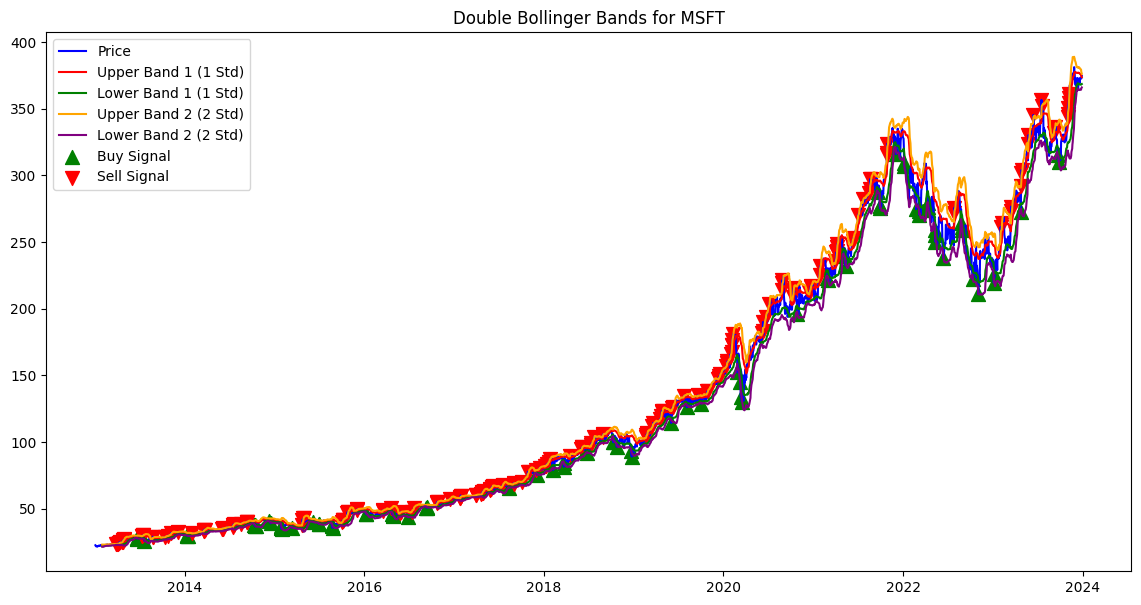

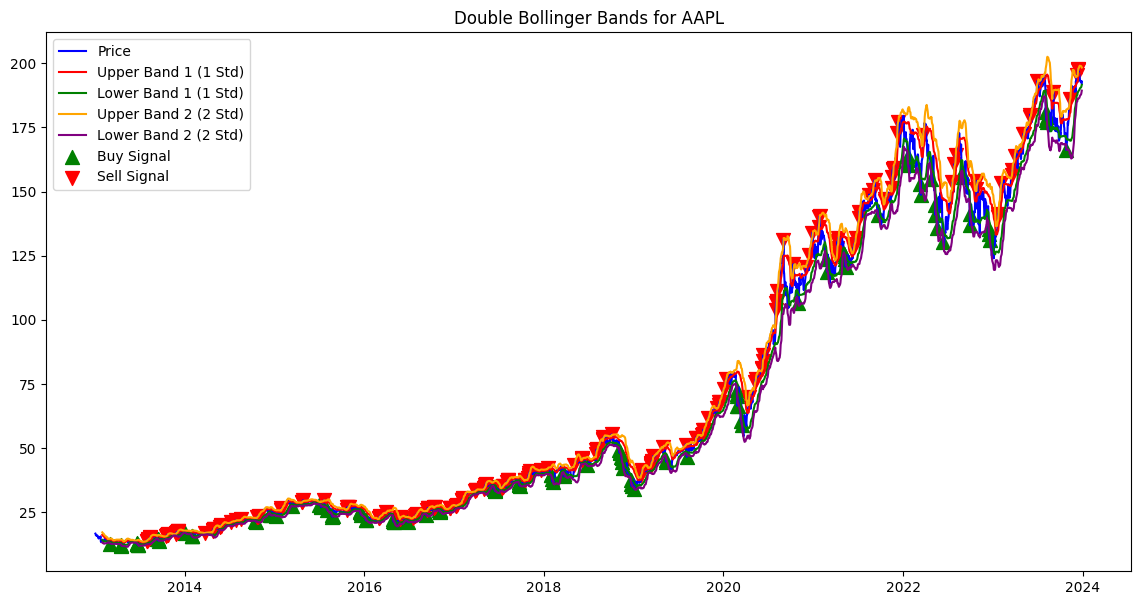

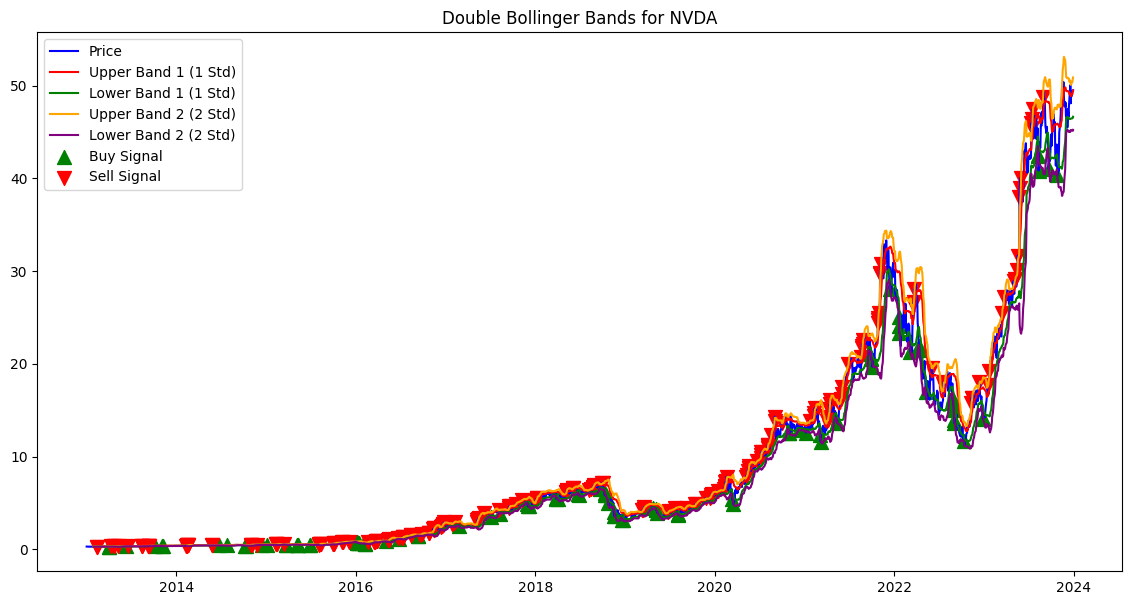

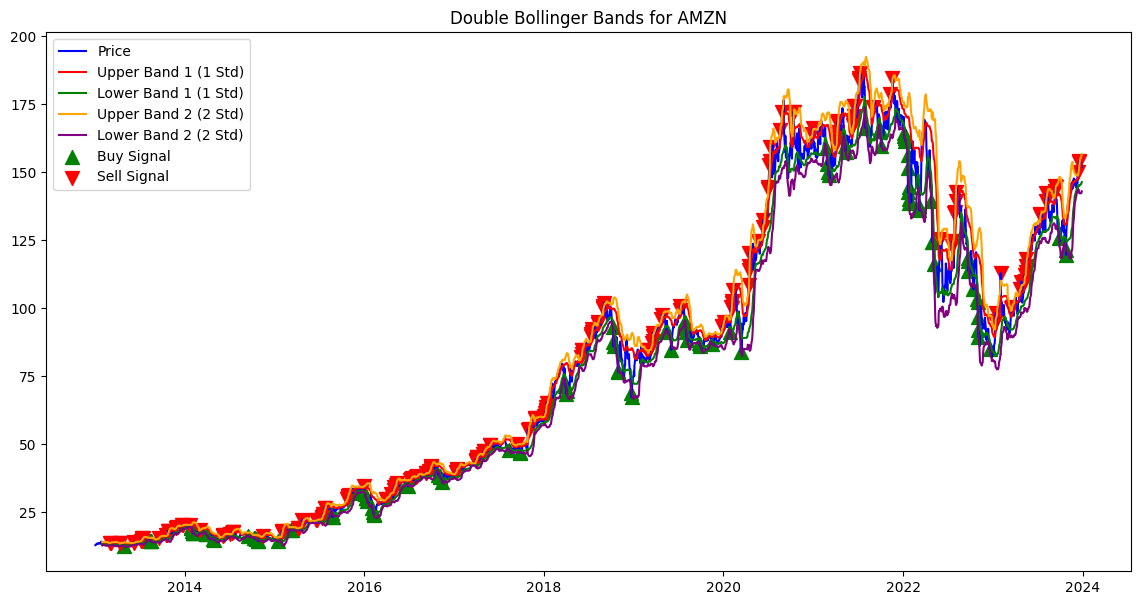

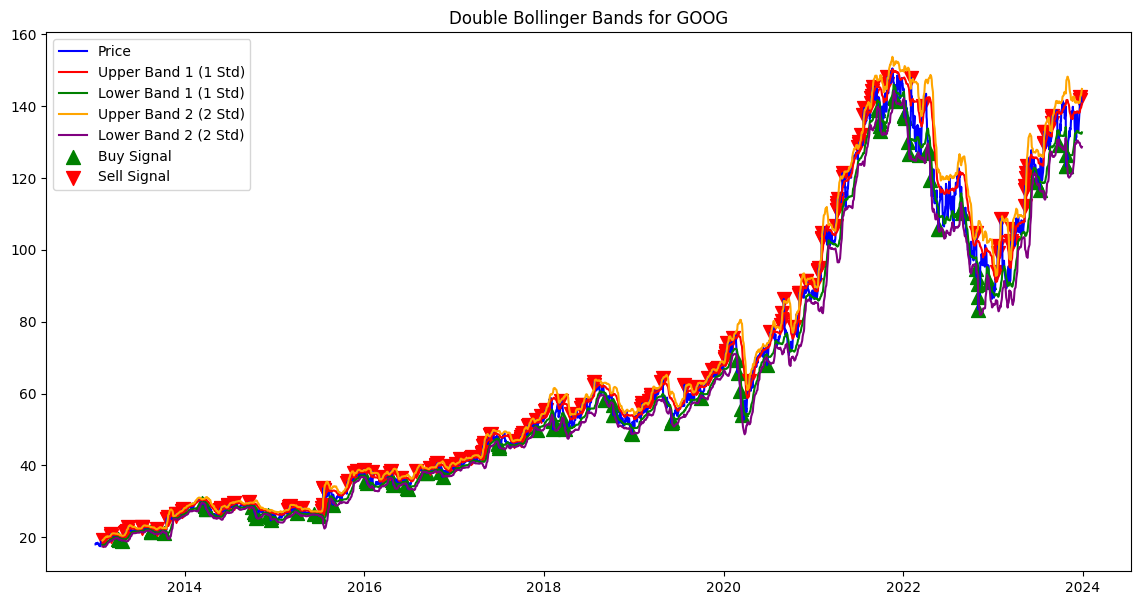

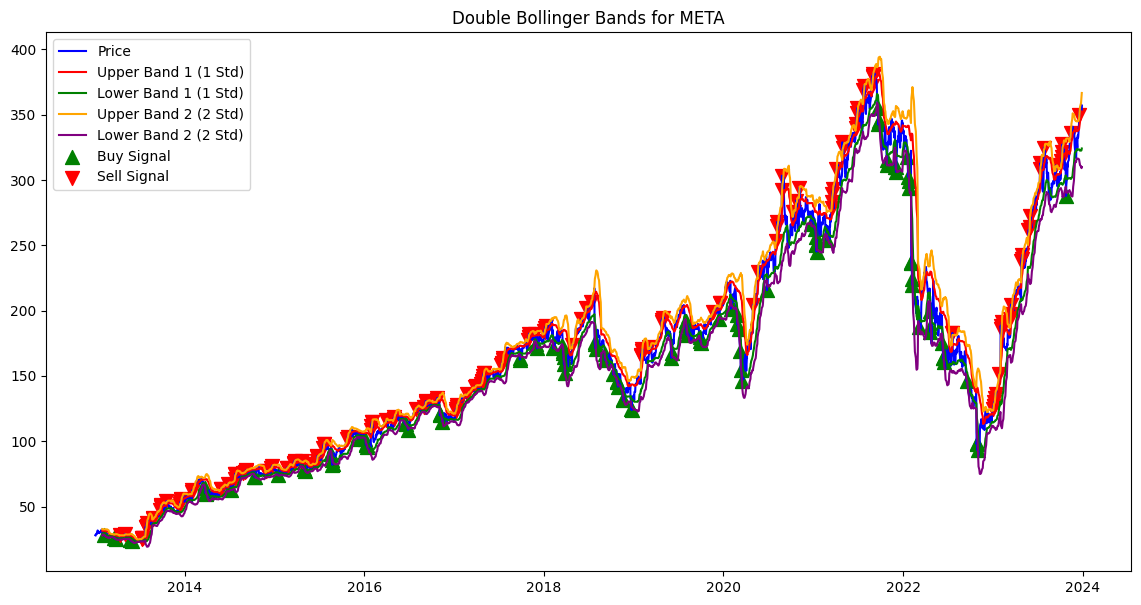

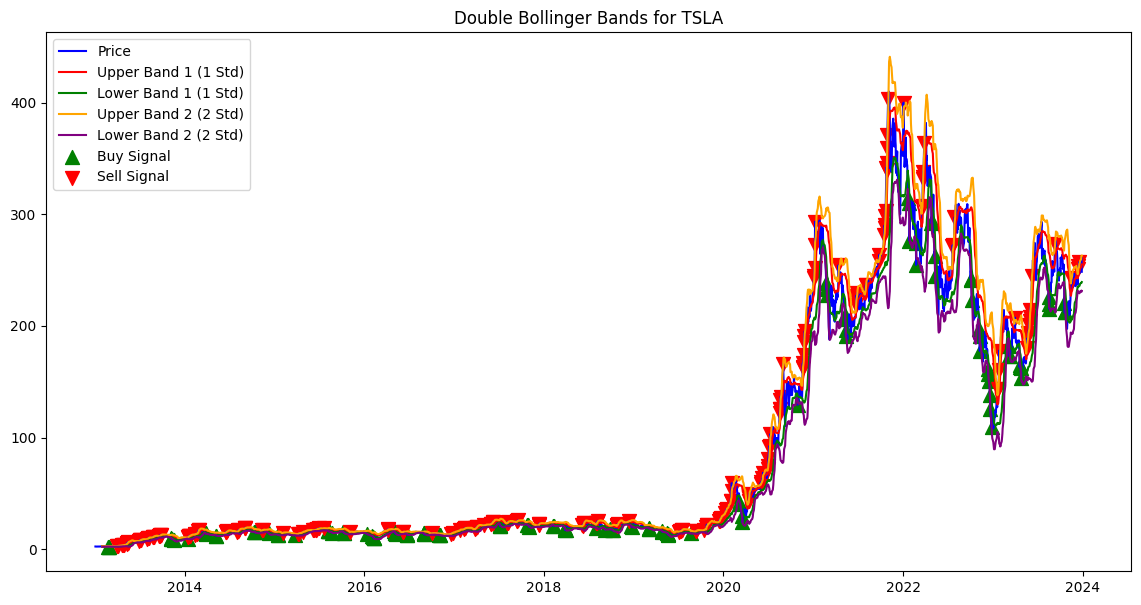

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Extract Historical Price Data
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOG', 'META', 'TSLA']
start_date = '2013-01-01'
end_date = '2023-12-31'

# Fetch data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Step 2: Implement the Double Bollinger Band Indicator
def double_bollinger_bands(df, ticker, window=20, no_of_std1=1, no_of_std2=2):
    rolling_mean = df[ticker].rolling(window).mean()
    rolling_std = df[ticker].rolling(window).std()
    
    upper_band1 = rolling_mean + (rolling_std * no_of_std1)
    lower_band1 = rolling_mean - (rolling_std * no_of_std1)
    upper_band2 = rolling_mean + (rolling_std * no_of_std2)
    lower_band2 = rolling_mean - (rolling_std * no_of_std2)
    
    df['Upper_Band1'] = upper_band1
    df['Lower_Band1'] = lower_band1
    df['Upper_Band2'] = upper_band2
    df['Lower_Band2'] = lower_band2
    
    df['Buy_Signal'] = np.where(df[ticker] < df['Lower_Band1'], 1, 0)
    df['Sell_Signal'] = np.where(df[ticker] > df['Upper_Band1'], 1, 0)
    
    return df

# Applying Double Bollinger Bands on all tickers
signals = {}
for ticker in tickers:
    df = data[[ticker]].copy()
    signals[ticker] = double_bollinger_bands(df, ticker)

# Step 3: Design a Backtesting Loop
initial_capital = 10000
min_transaction_size = 1

def backtest(signals, initial_capital, min_transaction_size):
    capital = initial_capital
    position = 0
    cash = initial_capital
    portfolio_value = []
    
    for date, row in signals.iterrows():
        if row['Buy_Signal'] and cash >= row[ticker] * min_transaction_size:
            shares_to_buy = min_transaction_size
            cash -= shares_to_buy * row[ticker]
            position += shares_to_buy
        
        elif row['Sell_Signal'] and position >= min_transaction_size:
            shares_to_sell = min_transaction_size
            cash += shares_to_sell * row[ticker]
            position -= shares_to_sell
        
        total_value = cash + (position * row[ticker])
        portfolio_value.append(total_value)
    
    return portfolio_value

# Running backtest for each stock
results = {}
for ticker in tickers:
    signals[ticker]['Adj Close'] = data[ticker]
    results[ticker] = backtest(signals[ticker], initial_capital, min_transaction_size)

# Step 4: Compute Performance Metrics
def compute_performance_metrics(portfolio_value, initial_capital):
    returns = np.diff(portfolio_value) / portfolio_value[:-1]
    total_return = (portfolio_value[-1] - initial_capital) #Actual Amount
    annual_return = np.mean(returns) * 252 #Expressed as %, time-weighted annual percentage.
    annual_volatility = np.std(returns) * np.sqrt(252) #Standard dev * sqrt(252)
    sharpe_ratio = annual_return / annual_volatility #(Expected return - rfr) / standard deviation
    downside_returns = returns[returns < 0]
    sortino_ratio = annual_return / (np.std(downside_returns) * np.sqrt(252)) #(Expected return - rfr) / standard deviation of negative returns
    max_drawdown = np.min(portfolio_value) / initial_capital - 1 #(trough - peak) / peak --> this is negative, need to abs
    
    return {
        "Total Return": total_return,
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Maximum Drawdown": max_drawdown
    }

# Computing metrics for each stock
metrics = {}
for ticker in tickers:
    metrics[ticker] = compute_performance_metrics(results[ticker], initial_capital)

# Display results
for ticker in tickers:
    print(f"Metrics for {ticker}:")
    for key, value in metrics[ticker].items():
        print(f"{key}: {value:.2f}")
    print("\n")

# Plotting the Double Bollinger Bands
def plot_double_bollinger_bands(df, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(df[ticker], label='Price', color='blue')
    plt.plot(df['Upper_Band1'], label='Upper Band 1 (1 Std)', color='red')
    plt.plot(df['Lower_Band1'], label='Lower Band 1 (1 Std)', color='green')
    plt.plot(df['Upper_Band2'], label='Upper Band 2 (2 Std)', color='orange')
    plt.plot(df['Lower_Band2'], label='Lower Band 2 (2 Std)', color='purple')
    
    buy_signals = df[df['Buy_Signal'] == 1]
    sell_signals = df[df['Sell_Signal'] == 1]
    plt.scatter(buy_signals.index, buy_signals[ticker], marker='^', color='green', alpha=1, label='Buy Signal', s=100)
    plt.scatter(sell_signals.index, sell_signals[ticker], marker='v', color='red', alpha=1, label='Sell Signal', s=100)
    
    plt.title(f'Double Bollinger Bands for {ticker}')
    plt.legend()
    plt.show()

# Plotting for each stock
for ticker in tickers:
    plot_double_bollinger_bands(signals[ticker], ticker)
